In [3]:
# Data Manipulation and Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Evaluation metrics and visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Ensure GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import itertools
import time
import csv
import json
from IPython.display import Audio, display
import winsound
from threading import Thread

Using device: cuda


In [4]:
# Load cleaned dataset
df = pd.read_csv('BTC_1h_w_Diffs.csv', parse_dates=['open_time'])

# Convert to datetime 
df['open_time'] = pd.to_datetime(df['open_time'])
df['close_time'] = pd.to_datetime(df['close_time'])

In [5]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, lstm_dim, dense_dim, output_dim, num_layers=1, dropout=0.0, activation_function=nn.ReLU):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
        self.fc1 = nn.Linear(lstm_dim, dense_dim)
        self.activation = activation_function()
        self.fc2 = nn.Linear(dense_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Helper functions
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def prepare_data(df, target_column, window_size, feature_columns):
    X = df[feature_columns].values
    y = df[target_column].values.reshape(-1, 1)
    
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y

def plot_loss_over_epochs(training_loss, validation_loss, file_prefix, start_epoch=5):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_epoch, len(training_loss)), training_loss[start_epoch:], label='Training Loss')
    plt.plot(range(start_epoch, len(validation_loss)), validation_loss[start_epoch:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.savefig(f'{file_prefix}_loss_plot.png')
    plt.show()

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

def save_predictions(y_train, y_train_pred, y_test, y_test_pred, file_path):
    predictions = {
        "y_train": y_train.tolist(),
        "y_train_pred": y_train_pred.tolist(),
        "y_test": y_test.tolist(),
        "y_test_pred": y_test_pred.tolist()
    }
    with open(file_path, 'w') as f:
        json.dump(predictions, f)

def save_metrics(metrics, file_path):
    with open(file_path, 'w') as f:
        json.dump(metrics, f)

def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False):
    result = {}  # Initialise result
    try:
        # Extract parameters
        window_size = params['window_size']
        lstm_dim = params['lstm_dim']
        dense_dim = params['dense_dim']
        num_layers = params['num_layers']
        dropout = params['dropout']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']
        optimizer_type = params['optimizer_type']
        patience = params['patience']
        activation_function = params['activation_function']

        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Prepare data
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        # Model parameters
        input_dim = X_train_tensor.shape[2]
        output_dim = 1

        model = LSTMModel(input_dim, lstm_dim, dense_dim, output_dim, num_layers, dropout, activation_function).to(device)

        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

        # Training loop
        best_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        training_losses = []
        validation_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader)
            training_losses.append(epoch_train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()

            val_loss /= len(test_loader)
            validation_losses.append(val_loss)

            if use_early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        break

        training_time = time.time() - start_time

        # Save the final model if early stopping was not used or not triggered
        if not use_early_stopping or patience_counter < patience:
            torch.save(model.state_dict(), f'{file_prefix}_{target_column}_final_model.pth')

        # Evaluate the model
        model.eval()
        evaluation_start_time = time.time()
        with torch.no_grad():
            train_predictions = model(X_train_tensor).cpu().numpy()
            test_predictions = model(X_test_tensor).cpu().numpy()

            # Inverse transform predictions and actual values
            train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
            test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
            y_train_inverse = scaler_y.inverse_transform(y_train_seq)
            y_test_inverse = scaler_y.inverse_transform(y_test_seq)

            # # Invert log transformation if the target variable was log-transformed
            # if target_column.startswith('log_'):
            #     train_predictions_inverse = np.exp(train_predictions_inverse) - 1
            #     test_predictions_inverse = np.exp(test_predictions_inverse) - 1
            #     y_train_inverse = np.exp(y_train_inverse) - 1
            #     y_test_inverse = np.exp(y_test_inverse) - 1

            train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
            test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
            train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
            test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
            test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

            train_directional_acc = np.mean(np.sign(y_train_inverse[1:] - y_train_inverse[:-1]) == np.sign(train_predictions_inverse[1:] - train_predictions_inverse[:-1]))
            test_directional_acc = np.mean(np.sign(y_test_inverse[1:] - y_test_inverse[:-1]) == np.sign(test_predictions_inverse[1:] - test_predictions_inverse[:-1]))

        evaluation_time = time.time() - evaluation_start_time

        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "train_mse": train_mse,
            "test_mse": test_mse,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_directional_acc": train_directional_acc,
            "test_directional_acc": test_directional_acc,
            "training_time": training_time,
            "evaluation_time": evaluation_time,
            "patience": patience,
            "activation_function": activation_function.__name__
        }

        # Save result to a CSV file
        with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=result.keys())
            if f.tell() == 0:
                writer.writeheader()  # Write header only if file is empty
            writer.writerow(result)

        # Save predictions and metrics
        save_predictions(y_train_inverse, train_predictions_inverse, y_test_inverse, test_predictions_inverse, f'{file_prefix}_{target_column}_predictions.json')
        save_metrics(result, f'{file_prefix}_{target_column}_metrics.json')

        # Plot loss over epochs if specified
        if plot_loss:
            plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=3)

        # Print summary of the results
        print(f"Results: Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"Train Directional Accuracy: {train_directional_acc:.4f}, Test Directional Accuracy: {test_directional_acc:.4f}")
        print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

    except Exception as e:
        print(f"An error occurred: {e}")
        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "error": str(e)
        }

    return result

In [6]:
# Define parameter space for a single run
params = {
    'window_size': 24,
    'lstm_dim': 150,
    'dense_dim': 190,
    'num_layers': 1,
    'dropout': 0.001,
    'lr': 0.0001,
    'num_epochs': 150,
    'batch_size': 64,
    'optimizer_type': 'Adam',
    'patience': 24,
    'activation_function': nn.Tanh
}

In [7]:
# Define target column and feature combination
target_column = 'log_diff'
features = ['diff_log_high', 'diff_log_low', 'log_high', 'log_low', 'log_close', 'log_diff', 'volume',
            'quote_vol', 'count', 'buy_base', 'buy_quote', 'high_p', 'low_p', 'close_p']

# Run the model
train_and_evaluate(df, target_column=target_column, feature_columns=features, params=params, file_prefix='model_eval', use_early_stopping=False, plot_loss=True)

KeyboardInterrupt: 

In [ ]:
# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, lstm_dim, dense_dim, output_dim, num_layers=1, dropout=0.0, activation_function=nn.ReLU):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
        self.fc1 = nn.Linear(lstm_dim, dense_dim)
        self.activation = activation_function()
        self.fc2 = nn.Linear(dense_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# Helper functions
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def prepare_data(df, target_column, window_size, feature_columns):
    X = df[feature_columns].values
    y = df[target_column].values.reshape(-1, 1)
    
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y

def plot_loss_over_epochs(training_loss, validation_loss, file_prefix, start_epoch=5):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_epoch, len(training_loss)), training_loss[start_epoch:], label='Training Loss')
    plt.plot(range(start_epoch, len(validation_loss)), validation_loss[start_epoch:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.savefig(f'{file_prefix}_loss_plot.png')
    plt.show()

def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)

def save_predictions(y_train, y_train_pred, y_test, y_test_pred, file_path):
    predictions = {
        "y_train": y_train.tolist(),
        "y_train_pred": y_train_pred.tolist(),
        "y_test": y_test.tolist(),
        "y_test_pred": y_test_pred.tolist()
    }
    with open(file_path, 'w') as f:
        json.dump(predictions, f)

def save_metrics(metrics, file_path):
    with open(file_path, 'w') as f:
        json.dump(metrics, f)

def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False):
    result = {}  # Initialize result
    try:
        # Extract parameters
        window_size = params['window_size']
        lstm_dim = params['lstm_dim']
        dense_dim = params['dense_dim']
        num_layers = params['num_layers']
        dropout = params['dropout']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']
        optimizer_type = params['optimizer_type']
        patience = params['patience']
        activation_function = params['activation_function']

        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Prepare data
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        # Model parameters
        input_dim = X_train_tensor.shape[2]
        output_dim = 1

        model = LSTMModel(input_dim, lstm_dim, dense_dim, output_dim, num_layers, dropout, activation_function).to(device)

        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

        # Training loop
        best_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        training_losses = []
        validation_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader)
            training_losses.append(epoch_train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()

            val_loss /= len(test_loader)
            validation_losses.append(val_loss)

            if use_early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        break

        training_time = time.time() - start_time

        # Save the final model if early stopping was not used or not triggered
        if not use_early_stopping or patience_counter < patience:
            torch.save(model.state_dict(), f'{file_prefix}_{target_column}_final_model.pth')

        # Evaluate the model
        model.eval()
        evaluation_start_time = time.time()
        with torch.no_grad():
            train_predictions = model(X_train_tensor).cpu().numpy()
            test_predictions = model(X_test_tensor).cpu().numpy()

            # Inverse transform predictions and actual values
            train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
            test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
            y_train_inverse = scaler_y.inverse_transform(y_train_seq)
            y_test_inverse = scaler_y.inverse_transform(y_test_seq)

            # Invert log transformation if the target variable was log-transformed
            if target_column.startswith('log_'):
                train_predictions_inverse = np.exp(train_predictions_inverse) - 1
                test_predictions_inverse = np.exp(test_predictions_inverse) - 1
                y_train_inverse = np.exp(y_train_inverse) - 1
                y_test_inverse = np.exp(y_test_inverse) - 1

            train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
            test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
            train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
            test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
            test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

            train_directional_acc = np.mean(np.sign(y_train_inverse[1:] - y_train_inverse[:-1]) == np.sign(train_predictions_inverse[1:] - train_predictions_inverse[:-1]))
            test_directional_acc = np.mean(np.sign(y_test_inverse[1:] - y_test_inverse[:-1]) == np.sign(test_predictions_inverse[1:] - test_predictions_inverse[:-1]))

        evaluation_time = time.time() - evaluation_start_time

        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "train_mse": train_mse,
            "test_mse": test_mse,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_directional_acc": train_directional_acc,
            "test_directional_acc": test_directional_acc,
            "training_time": training_time,
            "evaluation_time": evaluation_time,
            "patience": patience,
            "activation_function": activation_function.__name__
        }

        # Save result to a CSV file
        with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=result.keys())
            if f.tell() == 0:
                writer.writeheader()  # Write header only if file is empty
            writer.writerow(result)

        # Save predictions and metrics
        save_predictions(y_train_inverse, train_predictions_inverse, y_test_inverse, test_predictions_inverse, f'{file_prefix}_{target_column}_predictions.json')
        save_metrics(result, f'{file_prefix}_{target_column}_metrics.json')

        # Plot loss over epochs if specified
        if plot_loss:
            plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=3)

        # Print summary of the results
        print(f"Results: Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"Train Directional Accuracy: {train_directional_acc:.4f}, Test Directional Accuracy: {test_directional_acc:.4f}")
        print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

    except Exception as e:
        print(f"An error occurred: {e}")
        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "error": str(e)
        }

    return result

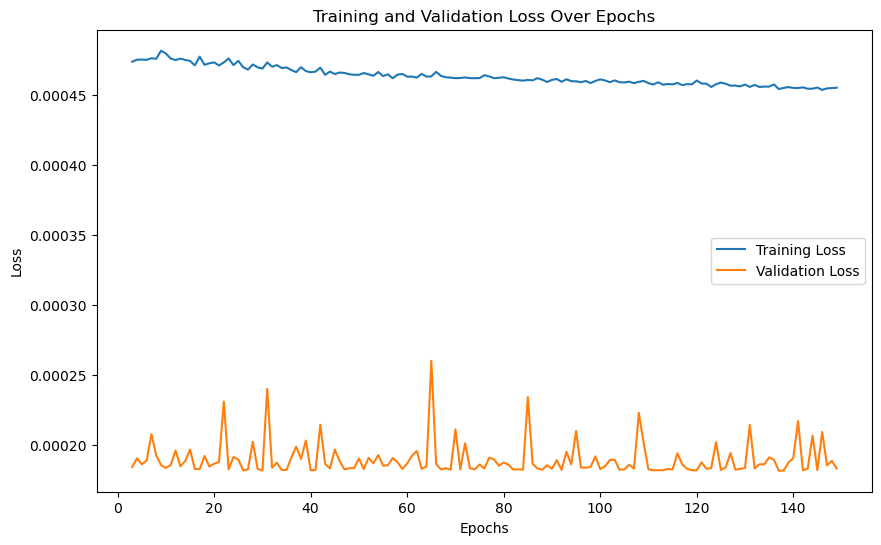

Results: Train MAE: 0.0046, Test MAE: 0.0030
Train Directional Accuracy: 0.5453, Test Directional Accuracy: 0.5534
Training Time: 183.7142 seconds, Evaluation Time: 0.4338 seconds



{'window_size': 24,
 'lstm_dim': 150,
 'num_layers': 1,
 'dense_dim': 190,
 'dropout': 0.001,
 'lr': 0.0001,
 'batch_size': 64,
 'num_epochs': 150,
 'optimizer_type': 'Adam',
 'train_mse': 5.809315852442e-05,
 'test_mse': 2.369067003907576e-05,
 'train_mae': 0.004637701562155997,
 'test_mae': 0.0030344419635995735,
 'train_rmse': 0.007621886808685891,
 'test_rmse': 0.004867306240527275,
 'train_r2': 0.027229356308489217,
 'test_r2': -0.00902505389254138,
 'train_directional_acc': 0.5452507335729122,
 'test_directional_acc': 0.5534108937070333,
 'training_time': 183.7141990661621,
 'evaluation_time': 0.4337918758392334,
 'patience': 24,
 'activation_function': 'Tanh'}

In [7]:
train_and_evaluate(df, target_column=target_column, feature_columns=features, params=params, file_prefix='model_eval', use_early_stopping=False, plot_loss=True)

In [ ]:
def plot_actual_vs_predicted(y_true, y_pred, title, file_prefix):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.savefig(f'{file_prefix}_actual_vs_predicted.png')
    plt.show()

In [8]:
plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=1)

NameError: name 'training_losses' is not defined

In [12]:
def plot_actual_vs_predicted_from_file(predictions_file, title, file_prefix):
    with open(predictions_file, 'r') as f:
        predictions = json.load(f)

    y_train = np.array(predictions['y_train'])
    y_train_pred = np.array(predictions['y_train_pred'])
    y_test = np.array(predictions['y_test'])
    y_test_pred = np.array(predictions['y_test_pred'])

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Test')
    plt.plot(y_test_pred, label='Predicted Test')
    plt.title(f'{title} (Test Set)')
    plt.legend()
    plt.xlim(6000, 6100)
    plt.ylim(50000, 60000)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.savefig(f'{file_prefix}_actual_vs_predicted_test.png')
    plt.show()


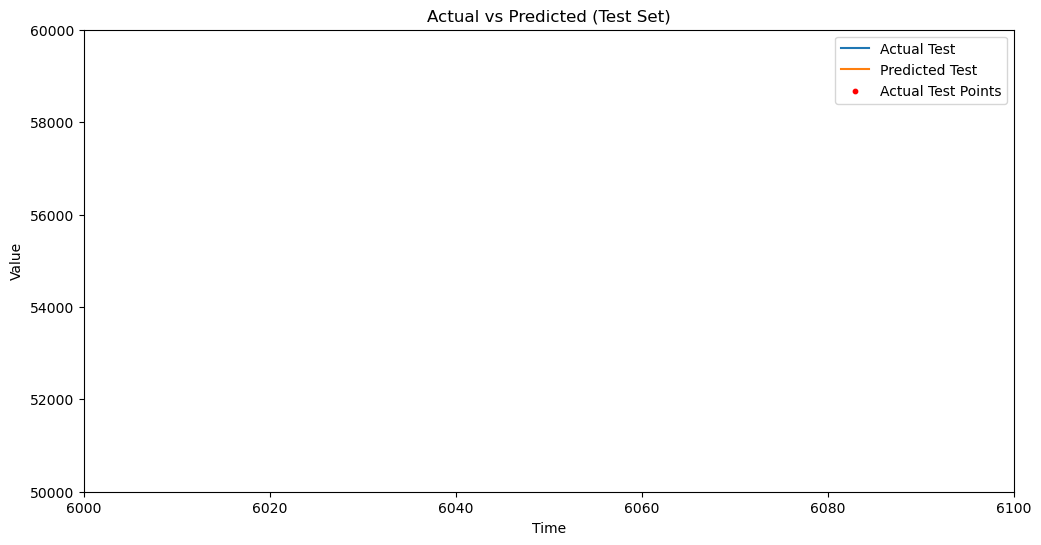

In [8]:
predictions_file = 'model_eval_log_diff_predictions.json'
plot_actual_vs_predicted_from_file(predictions_file, 'Actual vs Predicted', 'model_eval_log_diff')

In [17]:
# Define target column and feature combination
target_column = 'diff_log_close'
features = ['diff_log_high', 'diff_log_low', 'log_high', 'log_low', 'log_close', 'volume',
            'quote_vol', 'count', 'buy_base', 'buy_quote', 'high_p', 'low_p', 'close_p']

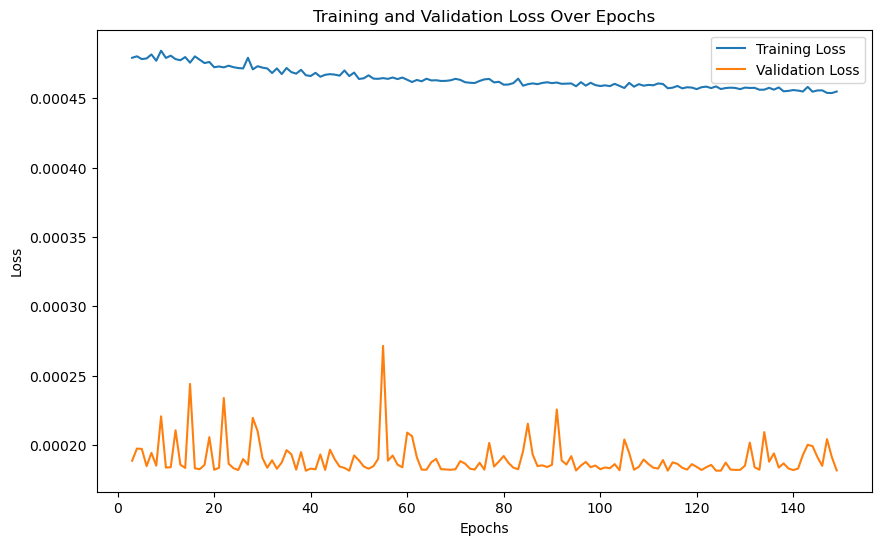

Results: Train MAE: 0.0046, Test MAE: 0.0030
Train Directional Accuracy: 0.5188, Test Directional Accuracy: 0.5293
Training Time: 183.7663 seconds, Evaluation Time: 0.4388 seconds



{'window_size': 24,
 'lstm_dim': 150,
 'num_layers': 1,
 'dense_dim': 190,
 'dropout': 0.001,
 'lr': 0.0001,
 'batch_size': 64,
 'num_epochs': 150,
 'optimizer_type': 'Adam',
 'train_mse': 5.863149215899231e-05,
 'test_mse': 2.3546373675359493e-05,
 'train_mae': 0.004639145381853264,
 'test_mae': 0.0030192077019726813,
 'train_rmse': 0.007657120356830779,
 'test_rmse': 0.004852460579475066,
 'train_r2': 0.023596623415350404,
 'test_r2': -0.002778758342932619,
 'train_directional_acc': 0.5187761695954634,
 'test_directional_acc': 0.5293495505023796,
 'training_time': 183.76634979248047,
 'evaluation_time': 0.43882250785827637,
 'patience': 24,
 'activation_function': 'Tanh'}

In [18]:
train_and_evaluate(df, target_column=target_column, feature_columns=features, params=params, file_prefix='model_eval', use_early_stopping=False, plot_loss=True)

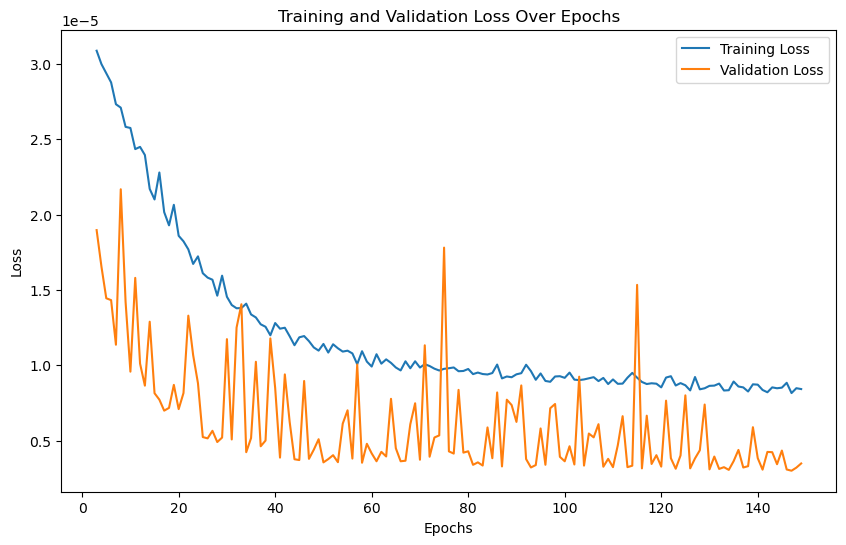

Results: Train MAE: 154.6847, Test MAE: 161.7196
Train Directional Accuracy: 0.4708, Test Directional Accuracy: 0.4726
Training Time: 184.8970 seconds, Evaluation Time: 0.4503 seconds



{'window_size': 24,
 'lstm_dim': 150,
 'num_layers': 1,
 'dense_dim': 190,
 'dropout': 0.001,
 'lr': 0.0001,
 'batch_size': 64,
 'num_epochs': 150,
 'optimizer_type': 'Adam',
 'train_mse': 72952.79566351802,
 'test_mse': 71657.6546409413,
 'train_mae': 154.6847157335556,
 'test_mae': 161.719627106741,
 'train_rmse': 270.0977520519525,
 'test_rmse': 267.68947428119264,
 'train_r2': 0.9997155805534362,
 'test_r2': 0.9996556843083559,
 'train_directional_acc': 0.47077247700372554,
 'test_directional_acc': 0.4726335272342676,
 'training_time': 184.89701175689697,
 'evaluation_time': 0.4503049850463867,
 'patience': 24,
 'activation_function': 'Tanh'}

In [19]:
# Define target column and feature combination
target_column = 'log_close'
features = ['log_high', 'log_low', 'log_close', 'volume',
            'quote_vol', 'count', 'buy_base', 'buy_quote', 'high_p', 'low_p', 'close_p']

train_and_evaluate(df, target_column=target_column, feature_columns=features, params=params, file_prefix='model_eval', use_early_stopping=False, plot_loss=True)

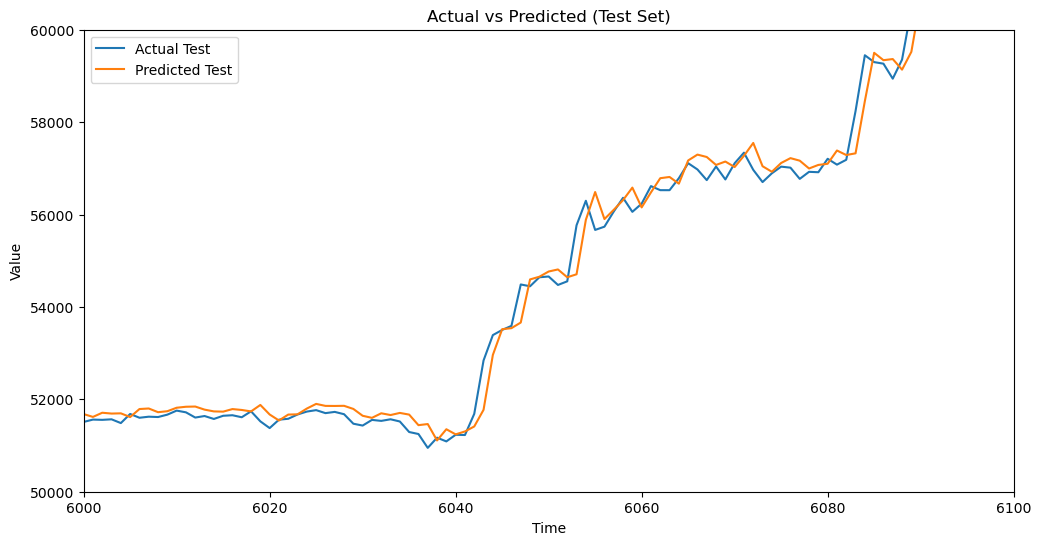

In [13]:
predictions_file = 'model_eval_log_close_predictions.json'
plot_actual_vs_predicted_from_file(predictions_file, 'Actual vs Predicted', 'model_eval_log_close')


In [21]:
def plot_actual_vs_predicted_from_file(predictions_file, title, file_prefix):
    with open(predictions_file, 'r') as f:
        predictions = json.load(f)

    y_train = np.array(predictions['y_train'])
    y_train_pred = np.array(predictions['y_train_pred'])
    y_test = np.array(predictions['y_test'])
    y_test_pred = np.array(predictions['y_test_pred'])

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Actual Test')
    plt.plot(y_test_pred, label='Predicted Test')
    
    # Add scatter plots of actual values
    plt.scatter(range(len(y_test)), y_test, color='black', s=15, label='Actual Test Points', marker='x')
    plt.scatter(range(len(y_test_pred)), y_test_pred, color='red', s=15, label='Predicted Test Points', marker='x')

    plt.title(f'{title} (Test Set)')
    plt.legend()
    plt.xlim(6000, 6100)
    plt.ylim(50000, 60000)
    plt.xlabel('Time')
    plt.ylabel('Value')
    # plt.savefig(f'{file_prefix}_actual_vs_predicted_test.png')
    plt.show()

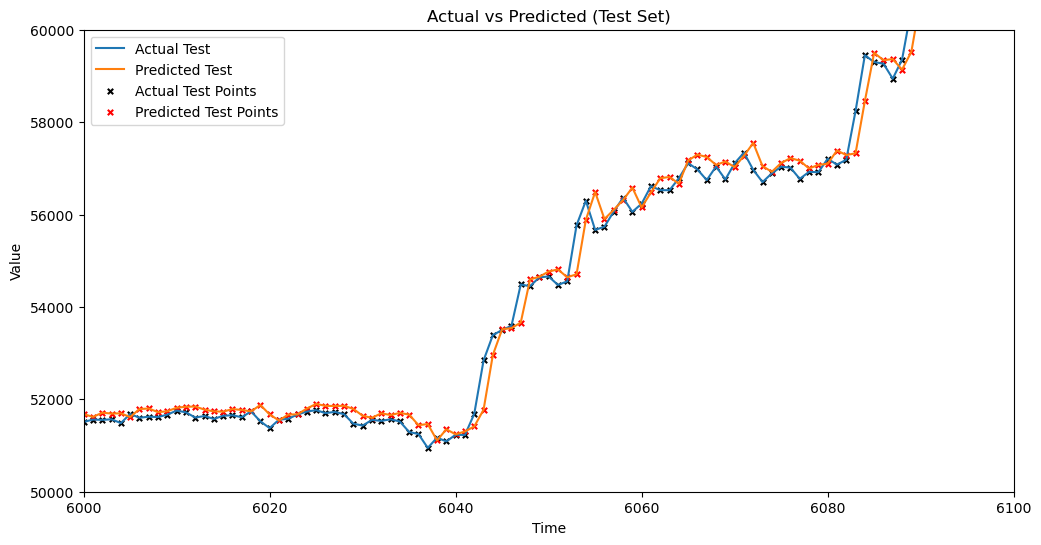

In [22]:
plot_actual_vs_predicted_from_file(predictions_file, 'Actual vs Predicted', 'model_eval_log_close')
